In [1]:
metrics_id = 0

In [2]:
# collect all metrics from path

import os
import glob
import pandas as pd

# Set the path to the main folder
main_folder = '/home/pgajo/working/data/metrics'

# Create an empty list to store DataFrames
dfs = []
# Iterate over all subfolders in the main folder
for root, dirs, files in os.walk(main_folder):
    # Iterate over all CSV files in the subfolder
    for file in glob.glob(os.path.join(root, '*.csv')):
        # Check if the filename starts with '0'
        if os.path.basename(file).startswith(str(metrics_id)):
            # Read the CSV file into a DataFrame
            temp_df = pd.read_csv(file)

            # Add the DataFrame to the list
            dfs.append(temp_df)

# Concatenate all DataFrames in the list
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.to_csv(os.path.join(main_folder,os.path.abspath(main_folder)+'_combined.csv')) # save merged df
combined_df['epoch'] = combined_df['epoch'].astype(int)

# Read in the original dataframe
df = combined_df

# Group by model and epoch to get the average test_f1 score for each combination
grouped_df = df.groupby(['model', 'epoch']).agg({'test_f1': 'mean'})

# Get the epoch with the highest average test_f1 score for each model
max_epochs = grouped_df.groupby('model')['test_f1'].idxmax()

# Create a new dataframe with rows for each model at their respective max epochs
best_epoch_df = pd.concat([combined_df[(combined_df['model'] == model_pair[0]) & (combined_df['epoch'] == model_pair[1])] for model_pair in [max_epoch for max_epoch in max_epochs]])
# Print the new dataframe
if 'train_loss' in best_epoch_df.columns:
    best_epoch_df=best_epoch_df.drop(['train_loss'], axis=1)
if 'eval_loss' in best_epoch_df.columns:
    best_epoch_df=best_epoch_df.drop(['eval_loss'], axis=1)
if 'test_loss' in best_epoch_df.columns:
    best_epoch_df=best_epoch_df.drop(['test_loss'], axis=1)
# combined_df

Model Performance Comparison - Best Epoch for Average Test F1


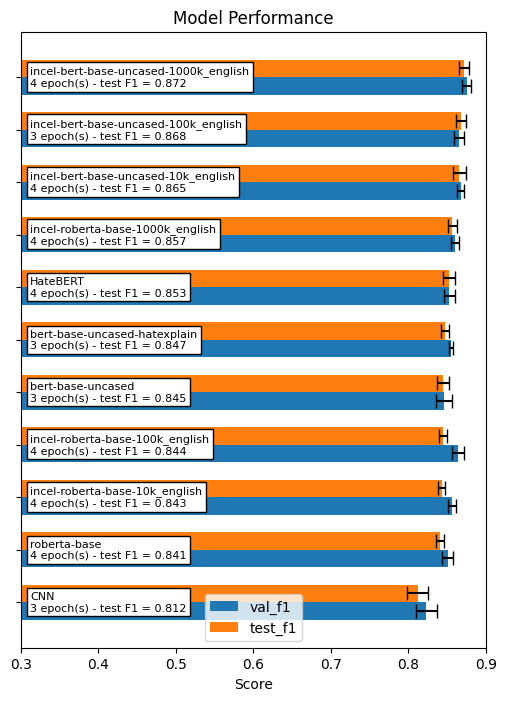

In [8]:
# Model Performance Comparison - Best Epoch for Average Test F1
print('Model Performance Comparison - Best Epoch for Average Test F1')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# df = combined_df
df = best_epoch_df

# Choose the metrics to display on the bar chart
# You can modify the list below to include the desired metrics
metrics = ["val_f1",
        #    "val_prec",
        #    "val_rec",
           "test_f1",
        #    "test_prec",
        #    "test_rec"
           ]

# Group data by model and calculate the mean and standard deviation for the chosen metrics
mean_df = df.groupby(['model', 'epoch'])[metrics].mean()
std_df = df.groupby(['model', 'epoch'])[metrics].std()

# Sort the dataframes by test_f1 in descending order
mean_df = mean_df.sort_values("test_f1", ascending=True)

top_test_f1 = mean_df['test_f1'].max()
min_test_f1 = mean_df['test_f1'].min()

std_df = std_df.reindex(mean_df.index)

# # Calculate the bar width and positions
# num_metrics = len(metrics)
# num_models = len(mean_df.index)
# bar_width = 1 / (num_metrics + 1)
# bar_positions = np.arange(num_models)

# # # Create a bar chart with error bars for standard deviation (VERTICAL)
# fig, ax = plt.subplots()
# for i, metric in enumerate(metrics):
#     ax.bar(
#         bar_positions + i * bar_width,
#         mean_df[metric],
#         yerr=std_df[metric],
#         width=bar_width,
#         label=metric,
#         capsize=5,
#     )

# Create a horizontal bar chart with error bars for standard deviation (HORIZONTAL)
# fig, ax = plt.subplots()
# for i, metric in enumerate(metrics):
#     ax.barh(
#         bar_positions + i * bar_width,
#         mean_df[metric],
#         xerr=std_df[metric],
#         height=bar_width,
#         label=metric,
#         capsize=5,
#     )


# Customize the chart
# VERTICAL
# ax.set_xticks(bar_positions + (num_metrics - 1) * bar_width / 2)
# ax.set_xticklabels([el[0]+'\n('+str(el[1])+' epochs)' for el in mean_df.index])
# ax.set_ylabel("Score")

# HORIZONTAL
# ax.set_yticks(bar_positions + (num_metrics - 1) * bar_width / 2)
# ax.set_yticklabels([el[0]+'\n('+str(el[1])+' epochs)' for el in mean_df.index])
# ax.set_xlabel("Score")

# ax.set_title("Model Performance")
# ax.legend()

# # Display the chart
# plt.xticks(rotation=45)
# plt.ylim(0.75, 0.9)
# plt.show()

# Calculate the bar width and positions
num_metrics = len(metrics)
num_models = len(mean_df.index)
bar_height = 1 / (num_metrics + 1)
bar_positions = np.arange(num_models)

# Create a horizontal bar chart with error bars for standard deviation
fig, ax = plt.subplots(
    figsize=(6, 8)
    )

for i, metric in enumerate(metrics):
    ax.barh(
        bar_positions + i * bar_height,
        mean_df[metric],
        xerr=std_df[metric],
        height=bar_height,
        label=metric,
        capsize=5,
    )

# Customize the chart
ax.set_yticks(bar_positions + (num_metrics - 1) * bar_height / 2)
ax.set_xlabel("Score")
ax.set_title("Model Performance")
ax.legend(loc='lower center')

# Display the chart
plt.yticks(rotation=45)
# xlim_left = min_test_f1 - (top_test_f1 - min_test_f1)/2
xlim_left = 0.3
# xlim_right = top_test_f1 + (top_test_f1 - min_test_f1)/2
xlim_right = 0.9
plt.xlim(xlim_left, xlim_right)

# Add model labels inside the graph with black border and white background
for i, (index, row) in enumerate(mean_df.iterrows()):
    model_label = index[0] + "\n" + str(index[1]) + " epoch(s)" + " - test F1 = " + str(round(row['test_f1'], 3))
    ypos = bar_positions[i] + (num_metrics - 1) * bar_height / 2
    xpos = xlim_left + (xlim_right - xlim_left)/50 # Adjust the x position to fit the label inside the bar
    ax.text(
        xpos,
        ypos,
        model_label,
        ha="left",
        va="center",
        fontsize=8,
        bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white"),
    )

# Remove the default yticklabels
ax.set_yticklabels([])

plt.show()

/home/pgajo/.local/share/virtualenvs/pgajo-Fz_qUQZq/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/pgajo/.local/share/virtualenvs/pgajo-Fz_qUQZq/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/pgajo/.local/share/virtualenvs/pgajo-Fz_qUQZq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/home/pgajo/.local/share/virtualenvs/pgajo-Fz_qUQZq/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/pgajo/.local/share/virtualenvs/pgajo-Fz_qUQZq/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/home/pgajo/.local/share/virtualenvs/pgajo-Fz_qUQZq/lib/py

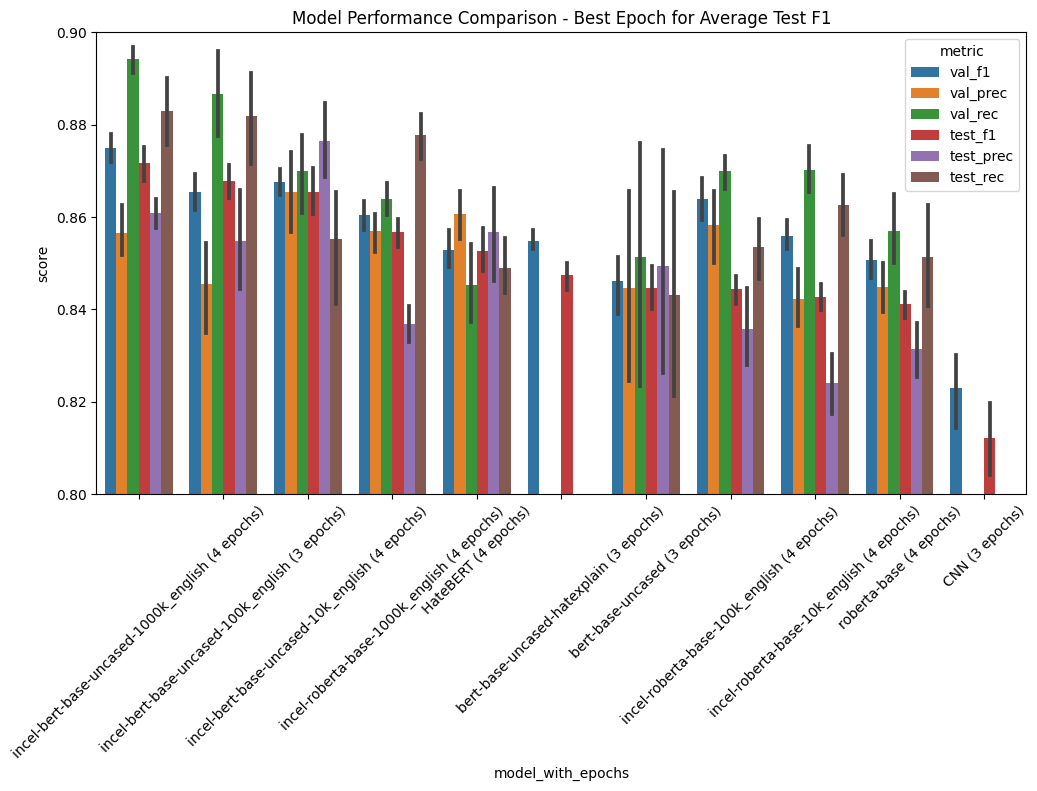

In [4]:
# Model Performance Comparison - Best Epoch for Average Test F1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_df is already the DataFrame you provided
mean_test_f1 = combined_df.groupby(['model', 'epoch'])['test_f1'].mean().reset_index()
best_mean_test_f1 = mean_test_f1.loc[mean_test_f1.groupby('model')['test_f1'].idxmax()]

# Merge the original combined_df with the best_mean_test_f1 to get the best epochs for each model
best_epochs = combined_df.merge(best_mean_test_f1[['model', 'epoch']], on=['model', 'epoch'])

# Add the number of epochs to the model names
best_epochs['model_with_epochs'] = best_epochs.apply(lambda row: f"{row['model']} ({int(row['epoch'])} epochs)", axis=1)

# Sort the DataFrame by test_f1 in descending order
best_epochs = best_epochs.sort_values(by='test_f1', ascending=False)

# Melt the DataFrame for easy visualization
df_melted = best_epochs.melt(id_vars=['model_with_epochs'], value_vars=['val_f1', 'val_prec', 'val_rec', 'test_f1', 'test_prec', 'test_rec'], var_name='metric', value_name='score')

# Create a sorted order based on the mean test_f1 for each model
sorted_order = best_epochs.groupby('model_with_epochs')['test_f1'].mean().sort_values(ascending=False).index

# Visualize the data using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='model_with_epochs', y='score', hue='metric', order=sorted_order)
plt.title('Model Performance Comparison - Best Epoch for Average Test F1')
plt.xticks(rotation=45)
plt.ylim(0.80, 0.9)
plt.show()


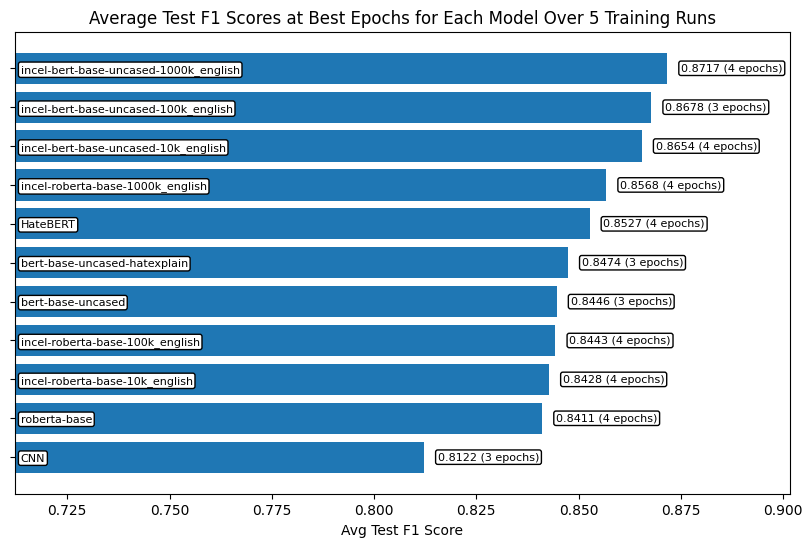

In [5]:
# Average Test F1 Scores at Best Epochs for Each Model Over 5 Training Runs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming combined_df is already the DataFrame you provided
mean_test_f1 = combined_df.groupby(['model', 'epoch'])['test_f1'].mean().reset_index()
best_mean_test_f1 = mean_test_f1.loc[mean_test_f1.groupby('model')['test_f1'].idxmax()]
best_mean_test_f1 = best_mean_test_f1.sort_values('test_f1')

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(best_mean_test_f1['model']))
bars = ax.barh(y_pos, best_mean_test_f1['test_f1'])

ax.set_yticks(y_pos)
label_background = dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')

ax.set_yticklabels(best_mean_test_f1['model'], ha='left', x=0.02, fontsize=8, bbox=label_background)
ax.set_xlabel('Avg Test F1 Score')
ax.set_title('Average Test F1 Scores at Best Epochs for Each Model Over 5 Training Runs')

for bar, row in zip(bars, best_mean_test_f1.itertuples()):
    annotation = f"{row.test_f1:.4f} ({int(row.epoch)} epochs)"
    bbox_props = dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
    ax.annotate(annotation, xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                xytext=(10, 0), textcoords='offset points', bbox=bbox_props, fontsize=8, va='center')

# Adjust the x-axis limits to display all annotations
plt.xlim(best_mean_test_f1['test_f1'].min() - 0.1, best_mean_test_f1['test_f1'].max() + 0.03)

plt.show()

/tmp/ipykernel_3329892/3874760103.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = best_df.groupby('model').mean()


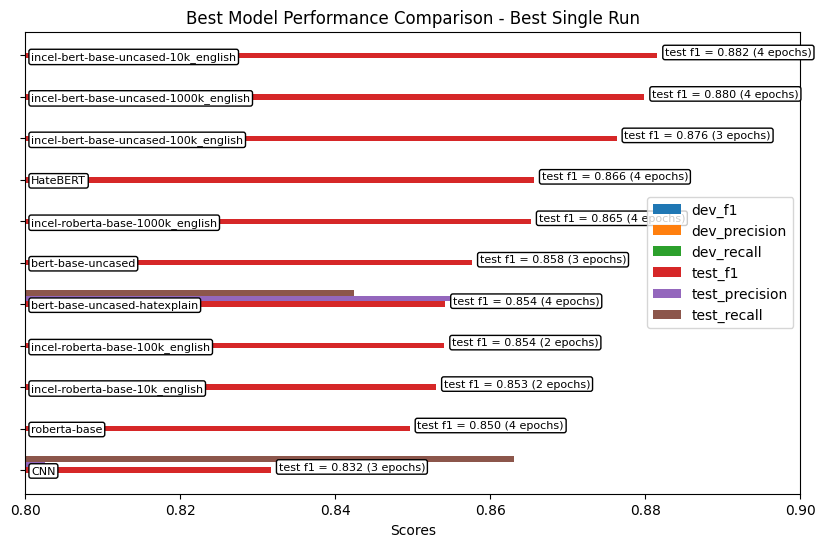

In [6]:
# Best Model Performance Comparison - Best Single Run

best_df=pd.DataFrame()
for model_name in combined_df['model'].value_counts().index:
    best_df=pd.concat([best_df,combined_df[combined_df['model']==model_name].sort_values(by='test_f1', ascending=False)[:1]])
best_df=best_df.sort_values(by='test_f1', ascending=False)
best_df.to_csv(os.path.join(main_folder,os.path.abspath(main_folder)+'_best_single_run_each_models.csv'))

import matplotlib.pyplot as plt
import numpy as np

# Group the dataframe by 'model' column
grouped_df = best_df.groupby('model').mean()

# Select the required columns
columns = ['dev_f1', 'dev_precision', 'dev_recall', 'test_f1', 'test_precision', 'test_recall']
data = grouped_df[columns]

# Sort the models by 'test_f1' column
data = data.sort_values('test_f1')

# Sort epoch values based on sorted 'test_f1' values
sorted_epochs = grouped_df.loc[data.index, 'epoch']

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the horizontal bar chart
bar_width = 0.8  # Set the bar width
y_pos = np.arange(len(data.index))  # Get the y positions for the bars

# Loop through each column and plot the bars
for i, column in enumerate(columns):
    bars = ax.barh(y_pos + i * bar_width / len(columns), data[column], height=bar_width / len(columns), label=column)
    if column == 'test_f1':
        for bar, (value, epoch) in zip(bars, zip(data[column], sorted_epochs)):
            ax.annotate(f"test f1 = {value:.3f} ({int(epoch)} epochs)",
                        xy=(value, bar.get_y() + bar.get_height() / 2),
                        xytext=(value + 0.001, bar.get_y() + bar.get_height() / 2),
                        fontsize=8,
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

# Add axis labels and title
ax.set_yticks(y_pos + bar_width / 2)

# Add background to the y-labels using bbox
label_background = dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
ax.set_yticklabels(data.index, ha='left', x=0.02, fontsize=8, bbox=label_background)

ax.set_xlabel('Scores')
ax.set_title('Best Model Performance Comparison - Best Single Run')

# Set legend and plot limits
ax.legend()
plt.xlim(0.8, 0.9)

# Display the plot
plt.show()
